In [2]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
from typing import Callable, Tuple


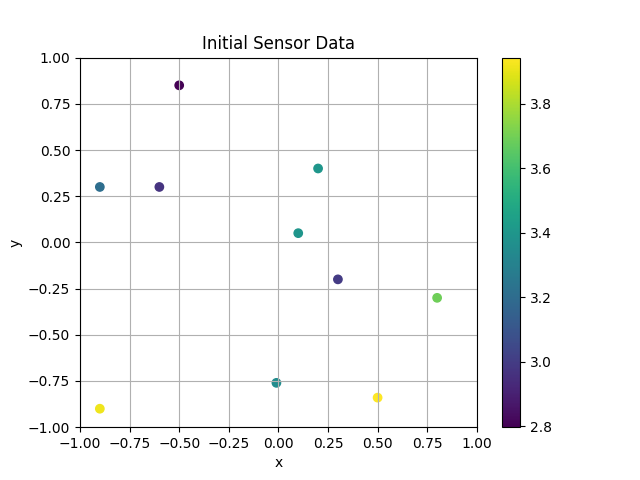

In [3]:
# Table 1: Initial Sensor Data
xdata0 = np.array([
    [0.1, -0.9, 0.2, 0.8, -0.6, 0.3, 0.5, -0.5, -0.01, -0.9],
    [0.05, 0.3, 0.4, -0.3, 0.3, -0.2, -0.84, 0.85, -0.76, -0.9]
])
ydata0 = np.array([
    3.39382006,
    3.2073034,
    3.39965035,
    3.68810201,
    2.96941623,
    2.99495501,
    3.94274928,
    2.7968011,
    3.34929734,
    3.91296165,
])
# define prior stuff that wont change
NUM_POINTS = 50
NOISE = 1e-2  # covariance of noise for each data point


def meanf(x):
    # prior mean function, just use the mean of the data
    return np.mean(ydata0) * np.ones((x.shape[1]))


# visualize the initial data with colors
plt.figure()
plt.scatter(xdata0[0], xdata0[1], c=ydata0)
plt.xlabel('x')
plt.xlim(-1, 1)
plt.ylabel('y')
plt.ylim(-1, 1)
plt.title('Initial Sensor Data')
plt.colorbar()
plt.grid()
plt.show()

In [37]:
# helper functions to run GPR
def sqexp(x: np.ndarray, xp: np.ndarray, tau: np.ndarray = [1, 1], l: np.ndarray = [0.5, 0.5]) -> np.ndarray:
    """Squared exponential kernel (2 dimensional).

    Args:
        x: (2, N) array of multiple inputs in 2D
        xp: (2,) array of the input at which the function values are known for each dimension

    Returns:
        cov (N,) -- Covariance between each input at *x* and the function values at *x*
    """
    cov0 = tau[0]**2 * np.exp(-1/2 * (x[0] - xp[0])**2 / l[0]**2)
    cov1 = tau[1]**2 * np.exp(-1/2 * (x[1] - xp[1])**2 / l[1]**2)
    return cov0*cov1


def periodic(x: np.ndarray, xp: np.ndarray, tau: np.ndarray = [1, 1], l: np.ndarray = [1, 1], p: np.ndarray = [0.4, 0.4]) -> np.ndarray:
    """Periodic kernel."""
    cov0 = tau[0]**2 * np.exp(-2 * np.sin(np.pi * np.abs(x[0] - xp[0]) / p[0])**2 / l[0]**2)
    cov1 = tau[1]**2 * np.exp(-2 * np.sin(np.pi * np.abs(x[1] - xp[1]) / p[1])**2 / l[1]**2)
    return cov0*cov1


def poly(x: np.ndarray, xp: np.ndarray, c: np.ndarray = [1, 1], d: np.ndarray[int] = [3, 3]):
    """Polynomial kernel."""
    cov0 = (x[0] * xp[0] + c[0])**d[0]
    cov1 = (x[1] * xp[1] + c[1])**d[1]
    return cov0*cov1


def comb_sqexp_per(x: np.ndarray, xp: np.ndarray,
                   ex_tau: np.ndarray = [1, 1], ex_l: np.ndarray = [0.5, 0.5],
                   pe_tau: np.ndarray = [1, 1], pe_l: np.ndarray = [1, 1], pe_p: np.ndarray = [0.4, 0.4]) -> np.ndarray:
    k1 = sqexp(x, xp, tau=ex_tau, l=ex_l)
    k2 = periodic(x, xp, tau=pe_tau, l=pe_l, p=pe_p)
    return k1*k2


kernel_options = {
    "Sq.Exp": sqexp,
    "Periodic": periodic,
    "Poly": poly,
    "Comb_Sq.Exp_Periodic": comb_sqexp_per
}


def build_covariance(x: np.ndarray, xp: np.ndarray, kern: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> np.ndarray:
    """Build a covariance matrix.

    Args:
        x: (2,N) array of x-y inputs in 2D
        xp: (2,M) array of x-y inputs in 2D
        kern: a function mapping inputs to covariance

    Outputs:
        cov: (N, M) covariance matrix
    """
    out = np.zeros((x.shape[1], xp.shape[1]))
    for jj in range(xp.shape[1]):
        # a single x-y data point is stored as a column vector
        out[:, jj] = kern(x, xp[:, jj])
    return out


def gpr(xtrain: np.ndarray,
        ytrain: np.ndarray,
        xpred: np.ndarray,
        noise_var: np.ndarray,
        mean_func: Callable[[np.ndarray], np.ndarray],
        kernel: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
    """Gaussian process regression Algorithm.

    Inputs:

        xtrain: (N, ) training inputs
        ytrain: (N, ) training outputs
        xpred:  (M, ) locations at which to make predictions
        noise_var: (N, ) noise at every training output
        mean_func: function to compute the prior mean
        kernel: covariance kernel

    Returns:
        pred_mean: (M, ) predicted mean at prediction points
        pred_cov: (M, M) predicted covariance at the prediction points
    """
    cov = build_covariance(xtrain, xtrain, kernel)
    # u, s, v = np.linalg.svd(cov)
    # sqrtcov = np.dot(u, np.sqrt(np.diag(s)))

    # pseudoinverse is better conditioned
    invcov = np.linalg.pinv(cov + np.diag(noise_var))

    pred_vec = build_covariance(xpred, xtrain, kernel)
    pred_mean = mean_func(xpred) + np.dot(pred_vec, np.dot(invcov, ytrain - mean_func(xtrain)))

    pred_cov_pre = build_covariance(xpred, xpred, kernel)
    pred_cov_up = np.dot(pred_vec, np.dot(invcov, pred_vec.T))
    pred_cov = pred_cov_pre - pred_cov_up

    return pred_mean, pred_cov


def plot_gpr(mean, cov, xdata, ydata, title, xextra=None, xextra_label=None):
    num_points = int(len(mean)**(1/2))  # assume square grid

    mesh_x, mesh_y = np.meshgrid(
        np.linspace(-1, 1, num_points), np.linspace(-1, 1, num_points))

    mean_mesh = mean.reshape((num_points, num_points))
    std = 2 * np.sqrt(np.diag(cov))
    std_mesh = std.reshape((num_points, num_points))

    # use separate levels so easier to see
    lmin = min(np.min(mean), np.min(ydata))
    lmax = max(np.max(mean), np.max(ydata))
    levels = np.linspace(lmin, lmax, 20)

    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    fig.tight_layout(pad=3)
    fig.suptitle(title, fontsize=14)

    # plot mean
    ax[0].contourf(mesh_x, mesh_y, mean_mesh, levels=levels)
    ax[0].scatter(xdata[0], xdata[1], c=ydata, vmin=lmin, vmax=lmax,
                  edgecolors='m', label='Sensor Data')
    if xextra is not None:
        ax[0].plot(xextra[0], xextra[1], 'rx', markersize=5, label=xextra_label)
    ax[0].set_title('Mean')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].legend()
    fig.colorbar(ax[0].collections[0], ax=ax[0], format='%.1f')

    # plot std

    lmin_std = min(np.min(std), np.min(std))
    lmax_std = max(np.max(std), np.max(std))
    levels_std = None
    if lmin_std != lmax_std:
        levels_std = np.linspace(lmin_std, lmax_std, 20)
    ax[1].contourf(mesh_x, mesh_y, std_mesh, levels=levels_std)
    ax[1].plot(xdata[0], xdata[1], 'm.', markersize=2, label='Sensor Data')
    if xextra is not None:
        ax[1].plot(xextra[0], xextra[1], 'rx', markersize=5, label=xextra_label)
    ax[1].set_title(r'2$\sigma$')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    ax[1].legend()
    fig.colorbar(ax[1].collections[0], ax=ax[1], format='%.1e')

    plt.show()

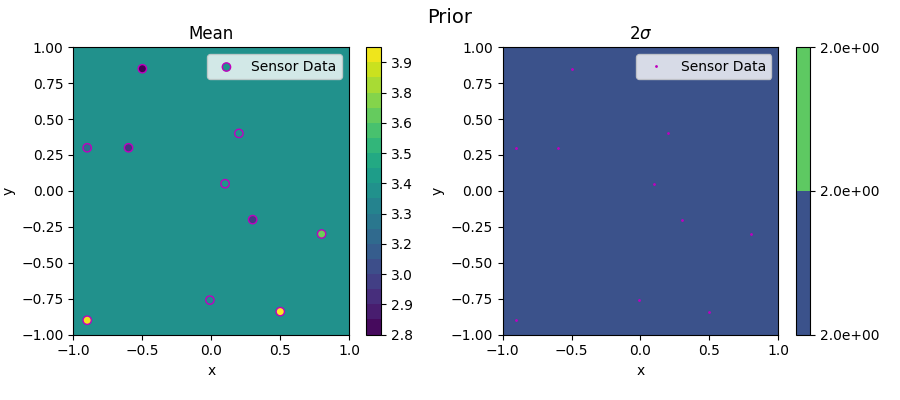

In [23]:
# plot prior
def plot_prior(xdata, ydata, num_pred_pts):
    xpred = np.zeros((2, num_pred_pts*num_pred_pts))
    for i in range(num_pred_pts):
        xpred[0, i*num_pred_pts:(i+1)*num_pred_pts] = np.linspace(-1, 1, num_pred_pts)
        xpred[1, i*num_pred_pts:(i+1)*num_pred_pts] = np.linspace(-1, 1, num_pred_pts)[i]

    def kernel(x, xp): return kernel_options["Sq.Exp"](x, xp)

    # build prior
    prior_mean = meanf(xpred)
    prior_cov = build_covariance(xpred, xpred, kernel)
    plot_gpr(prior_mean, prior_cov, xdata, ydata, 'Prior')


plot_prior(xdata0, ydata0, NUM_POINTS)

In [36]:
# functions to tune hyperparams

# maximizing likelihood because useful in low data regime
def log_likelihood(xdata, ydata, noise_cov, kernel):
    cov = build_covariance(xdata, xdata, kernel) + np.diag(noise_cov)
    invcov = np.linalg.pinv(cov)
    ydata = ydata - meanf(xdata)
    log_likelihood = -0.5 * (np.dot(ydata, np.dot(invcov, ydata)) +
                             np.linalg.slogdet(cov).logabsdet + len(ydata) * np.log(2 * np.pi))
    return log_likelihood


def tune_poly(xdata, ydata, noise):
    noise_cov = noise * np.ones(xdata.shape[1])

    # using shitty global search instead of scipy cos d needs to be an int
    lk_opt = -np.inf
    cs = np.linspace(0.1, 0.3, 100)
    ds = range(1, 3)
    c_opt = 0
    d_opt = 0
    for c in cs:
        for d in ds:
            def kernel(x, xp): return kernel_options["Poly"](x, xp, c=[c, c], d=[d, d])
            lk = log_likelihood(xdata, ydata, noise_cov, kernel)
            if lk > lk_opt:
                lk_opt = lk
                c_opt = c
                d_opt = d
    return c_opt, d_opt, lk_opt


def tune_sqexp(xdata, ydata, noise):
    noise_cov = noise * np.ones(xdata.shape[1])

    # using scipy to optimize
    def opt_sqexp(input):
        tau = input[0]
        l = input[1]
        def kernel(x, xp): return kernel_options["Sq.Exp"](x, xp, tau=[tau, tau], l=[l, l])
        return -log_likelihood(xdata, ydata, noise_cov, kernel)

    # opt = minimize(opt_sqexp, [1, 1])
    # opt = minimize(opt_sqexp, [0.1, 0.1])
    opt = minimize(opt_sqexp, [2, 2])
    # opt = minimize(opt_sqexp, [0.01, 0.01])
    # opt = minimize(opt_sqexp, [0.6951903807615231, 0.016159087538959192])
    # print(opt)

    return opt.x[0], opt.x[1], -opt.fun


def tune_periodic(xdata, ydata, noise):
    noise_cov = noise * np.ones(xdata.shape[1])

    # shitty global search, matches scipy
    # taus = np.linspace(0.1, 1, 20)
    # ls = np.linspace(0.01, 0.10, 20)
    # ps = np.linspace(70, 100, 50)
    # opt_tau = 0
    # opt_l = 0
    # opt_p = 0
    # opt_lk = -np.inf
    # for tau in taus:
    #     for l in ls:
    #         for p in ps:
    #             def kernel(x, xp): return kernel_options["Periodic"](
    #                 x, xp, tau=[tau, tau], l=[l, l], p=[p, p])
    #             lk = log_likelihood(xdata, ydata, noise_cov, kernel)
    #             if lk > opt_lk:
    #                 opt_lk = lk
    #                 opt_tau = tau
    #                 opt_l = l
    #                 opt_p = p
    # return opt_tau, opt_l, opt_p, opt_lk

    # using scipy to optimize
    def opt_periodic(input):
        tau = input[0]
        l = input[1]
        p = input[2]

        def kernel(x, xp): return kernel_options["Periodic"](
            x, xp, tau=[tau, tau], l=[l, l], p=[p, p])
        return -log_likelihood(xdata, ydata, noise_cov, kernel)

    opt = minimize(opt_periodic, [1, 1, 1])
    # xopt = minimize(opt_periodic, [5, 0.5, 1.4])
    # xopt = minimize(opt_periodic, [50,50,50])
    return opt.x[0], opt.x[1], opt.x[2], -opt.fun


def tune_sqexp_periodic(xdata, ydata, noise):
    noise_cov = noise * np.ones(xdata.shape[1])

    # using scipy to optimize
    def opt_combined(input):
        ex_tau = input[0]
        ex_l = input[1]
        pe_tau = input[2]
        pe_l = input[3]
        pe_p = input[4]

        def kernel(x, xp):
            return kernel_options["Comb_Sq.Exp_Periodic"](
                x, xp,
                ex_tau=[ex_tau, ex_tau], ex_l=[ex_l, ex_l],
                pe_tau=[pe_tau, pe_tau], pe_l=[pe_l, pe_l], pe_p=[pe_p, pe_p]
            )

        return -log_likelihood(xdata, ydata, noise_cov, kernel)

    # opt = minimize(opt_combined, [0.1, 0.1, 1, 1, 1])
    opt = minimize(opt_combined, [1, 1, 1, 1, 1])
    return opt.x[0], opt.x[1], opt.x[2], opt.x[3], opt.x[4], -opt.fun

Optimal hyperparams for Poly:
likelihood: -7.02
c: 0.22
d: 2.00


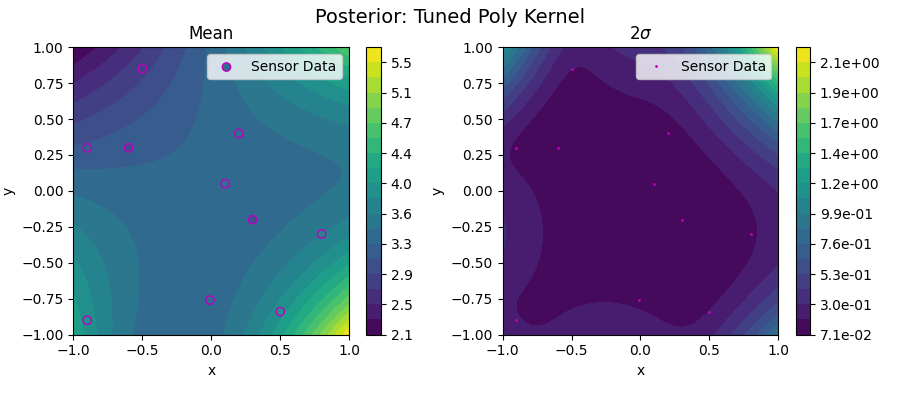

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.07225860519376
        x: [ 6.043e-01  2.732e-01]
      nit: 12
      jac: [ 1.848e-06 -2.027e-06]
 hess_inv: [[ 5.860e-03  3.029e-03]
            [ 3.029e-03  1.747e-02]]
     nfev: 72
     njev: 24
Optimal hyperparams for Sq.Exp:
likelihood: -4.07
tau: 0.60
l: 0.27


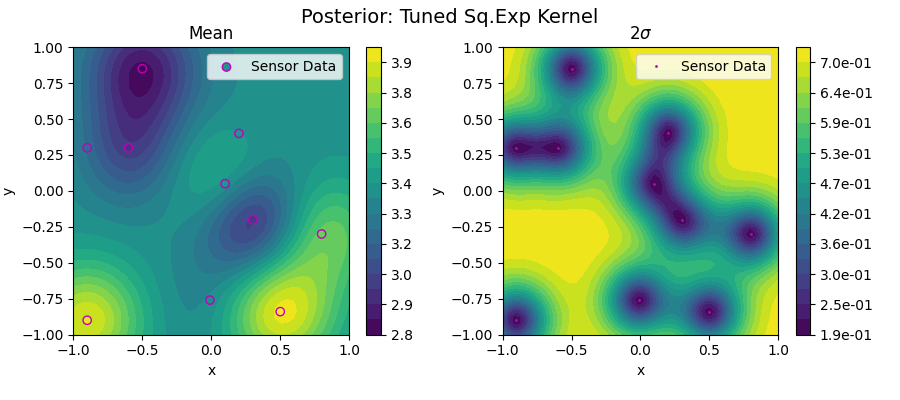

Optimal hyperparams for Periodic:
likelihood: -4.07
tau: 0.60
l: 0.02
p: 82.28


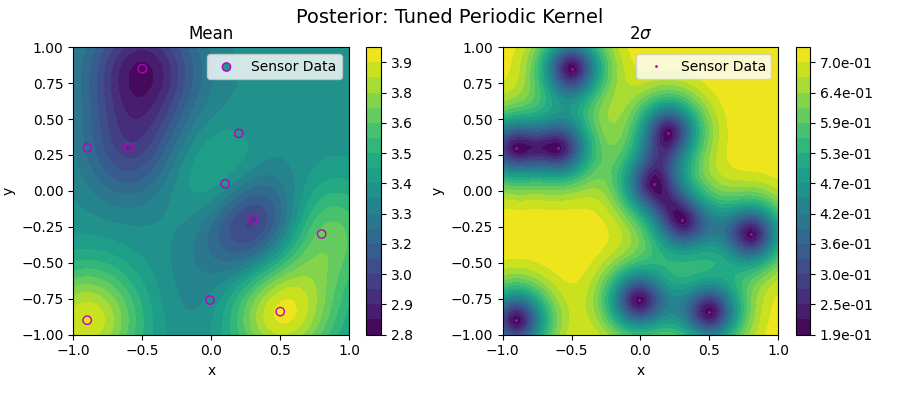

Optimal hyperparams for Combined:
likelihood: -4.25
ex_tau: 0.77
ex_l: 0.75
pe_tau: 0.77
pe_l: 0.82
pe_p: 0.94


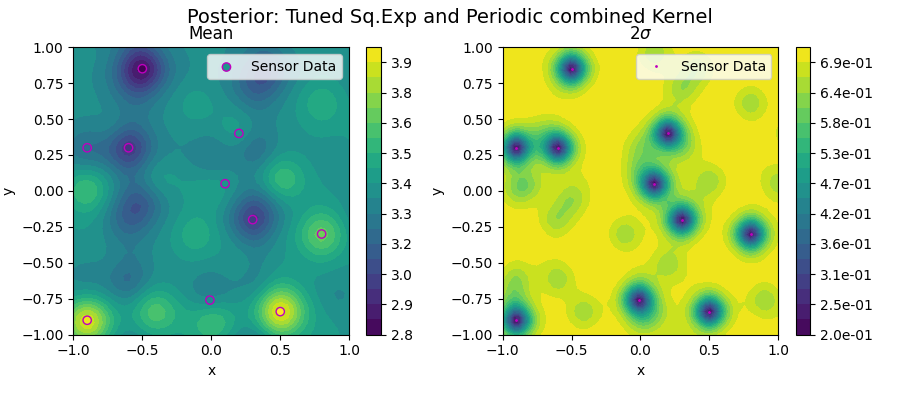

In [24]:
def explore_kernel_tuning(xdata, ydata, noise, num_pred_pts):
    noise_cov = noise * np.ones(xdata.shape[1])
    xpred = np.zeros((2, num_pred_pts*num_pred_pts))
    for i in range(num_pred_pts):
        xpred[0, i*num_pred_pts:(i+1)*num_pred_pts] = np.linspace(-1, 1, num_pred_pts)
        xpred[1, i*num_pred_pts:(i+1)*num_pred_pts] = np.linspace(-1, 1, num_pred_pts)[i]

    c_opt, d_opt, lk_opt = tune_poly(xdata, ydata, NOISE)
    print(
        f'Optimal hyperparams for Poly:\nlikelihood: {lk_opt:.2f}\nc: {c_opt:.2f}\nd: {d_opt:.2f}')

    def tuned_poly(x, xp):
        return kernel_options["Poly"](x, xp, c=[c_opt, c_opt], d=[d_opt, d_opt])

    pred_mean, pred_cov = gpr(xdata, ydata, xpred, noise_cov, meanf, tuned_poly)
    plot_gpr(pred_mean, pred_cov, xdata, ydata, 'Posterior: Tuned Poly Kernel')

    tau_opt, l_opt, lk_opt = tune_sqexp(xdata, ydata, NOISE)
    print(
        f'Optimal hyperparams for Sq.Exp:\nlikelihood: {lk_opt:.2f}\ntau: {tau_opt:.2f}\nl: {l_opt:.2f}')

    def tuned_sqexp(x, xp):
        return kernel_options["Sq.Exp"](x, xp, tau=[tau_opt, tau_opt], l=[l_opt, l_opt])

    pred_mean, pred_cov = gpr(xdata, ydata, xpred, noise_cov, meanf, tuned_sqexp)
    plot_gpr(pred_mean, pred_cov, xdata, ydata, 'Posterior: Tuned Sq.Exp Kernel')

    opt_tau, opt_l, opt_p, opt_lk = tune_periodic(xdata, ydata, NOISE)
    print(
        f'Optimal hyperparams for Periodic:\nlikelihood: {opt_lk:.2f}\ntau: {opt_tau:.2f}\nl: {opt_l:.2f}\np: {opt_p:.2f}')

    def tuned_periodic(x, xp):
        return kernel_options["Periodic"](x, xp, tau=[opt_tau, opt_tau], l=[opt_l, opt_l], p=[opt_p, opt_p])

    pred_mean, pred_cov = gpr(xdata, ydata, xpred, noise_cov, meanf, tuned_periodic)
    plot_gpr(pred_mean, pred_cov, xdata, ydata, 'Posterior: Tuned Periodic Kernel')

    opt_ex_tau, opt_ex_l, opt_pe_tau, opt_pe_l, opt_pe_p, opt_lk = tune_sqexp_periodic(
        xdata, ydata, NOISE)
    print(
        f'Optimal hyperparams for Combined:\nlikelihood: {opt_lk:.2f}\nex_tau: {opt_ex_tau:.2f}\nex_l: {opt_ex_l:.2f}\npe_tau: {opt_pe_tau:.2f}\npe_l: {opt_pe_l:.2f}\npe_p: {opt_pe_p:.2f}')

    def tuned_comb(x, xp):
        return kernel_options["Comb_Sq.Exp_Periodic"](
            x, xp,
            ex_tau=[opt_ex_tau, opt_ex_tau], ex_l=[opt_ex_l, opt_ex_l],
            pe_tau=[opt_pe_tau, opt_pe_tau], pe_l=[opt_pe_l, opt_pe_l], pe_p=[opt_pe_p, opt_pe_p]
        )

    pred_mean, pred_cov = gpr(xdata, ydata, xpred, noise_cov, meanf, tuned_comb)
    plot_gpr(pred_mean, pred_cov, xdata, ydata,
             'Posterior: Tuned Sq.Exp and Periodic combined Kernel')


explore_kernel_tuning(xdata0, ydata0, NOISE, NUM_POINTS)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.07225860519376
        x: [ 6.043e-01  2.732e-01]
      nit: 12
      jac: [ 1.848e-06 -2.027e-06]
 hess_inv: [[ 5.860e-03  3.029e-03]
            [ 3.029e-03  1.747e-02]]
     nfev: 72
     njev: 24
Optimal hyperparams for Sq.Exp:
likelihood: -4.07
tau: 0.60
l: 0.27
Data variance: 0.13818643899977315
Max Posterior variance: 0.1333973233393041


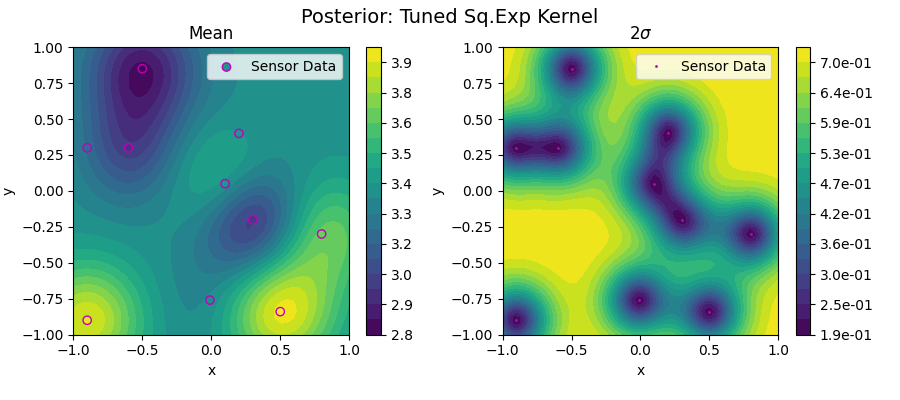

In [25]:
# function to optimize hyperparams and run GPR
def run_tuned_gpr(xdata, ydata, num_pred_pts, noise, meanf):
    noise_cov = noise * np.ones(xdata.shape[1])
    xpred = np.zeros((2, num_pred_pts*num_pred_pts))
    for i in range(num_pred_pts):
        xpred[0, i*num_pred_pts:(i+1)*num_pred_pts] = np.linspace(-1, 1, num_pred_pts)
        xpred[1, i*num_pred_pts:(i+1)*num_pred_pts] = np.linspace(-1, 1, num_pred_pts)[i]

    tau_opt, l_opt, lk_opt = tune_sqexp(xdata, ydata, noise)
    print(
        f'Optimal hyperparams for Sq.Exp:\nlikelihood: {lk_opt:.2f}\ntau: {tau_opt:.2f}\nl: {l_opt:.2f}')

    def kernel(x, xp):
        return kernel_options["Sq.Exp"](x, xp, tau=[tau_opt, tau_opt], l=[l_opt, l_opt])

    pred_mean, pred_cov = gpr(xdata, ydata, xpred, noise_cov, meanf, kernel)
    print(f'Data variance: {(np.var(ydata))}')
    pred_var = np.diag(pred_cov)
    print(f'Max Posterior variance: {np.max(pred_var)}')
    return pred_mean, pred_cov, kernel


pred_mean0, pred_cov0, kernel0 = run_tuned_gpr(xdata0, ydata0, NUM_POINTS, NOISE, meanf)
plot_gpr(pred_mean0, pred_cov0, xdata0, ydata0, 'Posterior: Tuned Sq.Exp Kernel')

In [26]:
# Acquisition functions
def acquire_reduce_var(kernel, xdata, ydata, num_pred_pts, new_pts):
    # acquire points that reduce overall variance
    noise_cov = NOISE * np.ones(xdata.shape[1])
    xpred = np.zeros((2, num_pred_pts*num_pred_pts))
    for i in range(num_pred_pts):
        xpred[0, i*num_pred_pts:(i+1)*num_pred_pts] = np.linspace(-1, 1, num_pred_pts)
        xpred[1, i*num_pred_pts:(i+1)*num_pred_pts] = np.linspace(-1, 1, num_pred_pts)[i]

    pred_mean, pred_cov = gpr(xdata, ydata, xpred, noise_cov, meanf, kernel)
    pred_cov_best = pred_cov.copy()
    xdata_aug = xdata.copy()
    ydata_aug = ydata.copy()
    for i in range(new_pts):
        # threshold the current uncertainty to get the viable points
        pred_var_temp = np.diag(pred_cov_best)
        pred_var_tot = np.sum(pred_var_temp)
        pred_var_max = np.max(pred_var_temp)
        var_thresh = 0.9*pred_var_max
        pred_var_thresh = pred_var_temp > var_thresh
        viable_x = xpred[:, pred_var_thresh]
        viable_y = pred_mean[pred_var_thresh]
        var_red_max = 0
        var_red_max_idx = 0
        # iterate through the viable points but skip every other one to reduce computation cost
        for pt_idx in range(0, len(viable_y), 2):
            print(f'Point {pt_idx+1} of {len(viable_y)}\t', end='\r')
            # add the point to the dataset with pred_mean as the value at that point
            xdata_temp = np.hstack((xdata_aug, viable_x[:, pt_idx].reshape(2, 1)))
            ydata_temp = np.append(ydata_aug, viable_y[pt_idx])
            # compute the new pred_var
            noise_cov_temp = NOISE * np.ones(xdata_temp.shape[1])
            _, pred_cov_temp = gpr(xdata_temp, ydata_temp, xpred, noise_cov_temp, meanf, kernel)
            # compute the new total uncertainty
            var_red = pred_var_tot - np.sum(np.diag(pred_cov_temp))
            if var_red > var_red_max:
                var_red_max = var_red
                var_red_max_idx = pt_idx
                pred_cov_best = pred_cov_temp

        xdata_aug = np.hstack((xdata_aug, viable_x[:, var_red_max_idx].reshape(2, 1)))
        ydata_aug = np.append(ydata_aug, viable_y[var_red_max_idx])
    return xdata_aug[:, -new_pts:]


def max_expected_improvement(pred_mean, pred_std, ymax, explore):
    # normalize
    z = (pred_mean - ymax - explore) / pred_std
    # return id of max expected improvement
    ei = pred_std * (z * norm.cdf(z) + norm.pdf(z))
    return np.argmax(ei), ei


def acquire_max_ei(kernel, xdata, ydata, num_pred_pts, new_pts, explore):
    # acquire points that maximize expected improvement
    noise_cov = NOISE * np.ones(xdata.shape[1])
    xpred = np.zeros((2, num_pred_pts*num_pred_pts))
    for i in range(num_pred_pts):
        xpred[0, i*num_pred_pts:(i+1)*num_pred_pts] = np.linspace(-1, 1, num_pred_pts)
        xpred[1, i*num_pred_pts:(i+1)*num_pred_pts] = np.linspace(-1, 1, num_pred_pts)[i]

    pred_mean, pred_cov = gpr(xdata, ydata, xpred, noise_cov, meanf, kernel)
    pred_cov_temp = pred_cov.copy()
    pred_mean_temp = pred_mean.copy()
    xdata_aug = xdata.copy()
    ydata_aug = ydata.copy()
    for i in range(new_pts):
        pred_std_temp = np.sqrt(np.diag(pred_cov_temp))
        idx_max_ei, max_ei = max_expected_improvement(
            pred_mean_temp, pred_std_temp, np.max(ydata_aug), explore)

        xdata_aug = np.hstack((xdata_aug, xpred[:, idx_max_ei].reshape(2, 1)))
        ydata_aug = np.append(ydata_aug, pred_mean[idx_max_ei])
        noise_cov_temp = NOISE * np.ones(xdata_aug.shape[1])
        pred_mean_temp, pred_cov_temp = gpr(
            xdata_aug, ydata_aug, xpred, noise_cov_temp, meanf, kernel)
    return xdata_aug[:, -new_pts:], max_ei

In [9]:
NUM_NEW_PTS_REDVAR = 4
new_pts_redvar = acquire_reduce_var(kernel0, xdata0, ydata0, NUM_POINTS, NUM_NEW_PTS_REDVAR)
print(f'New points from reducing variance:\n{new_pts_redvar.T}')

New points from reducing variance:
[[-0.55102041 -0.34693878]
 [ 0.71428571  0.63265306]
 [ 0.75510204  0.14285714]
 [ 0.02040816  0.79591837]]


In [27]:
NUM_NEW_PTS_EI = 4
new_pts_ei, ei = acquire_max_ei(kernel0, xdata0, ydata0, NUM_POINTS, NUM_NEW_PTS_EI, 2)
print(f'New points from maximizing expected improvement\n{new_pts_ei.T}')

New points from maximizing expected improvement
[[ 0.95918367 -0.79591837]
 [-1.         -0.42857143]
 [ 1.          0.2244898 ]
 [ 1.          1.        ]]


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 9.24130768999998
        x: [ 6.932e-01  2.816e-01]
      nit: 11
      jac: [-3.576e-07 -1.192e-07]
 hess_inv: [[ 5.321e-03  2.371e-03]
            [ 2.371e-03  9.606e-03]]
     nfev: 63
     njev: 21
Optimal hyperparams for Sq.Exp:
likelihood: -9.24
tau: 0.69
l: 0.28
Data variance: 0.23375071142350837
Max Posterior variance: 0.22368394671232184


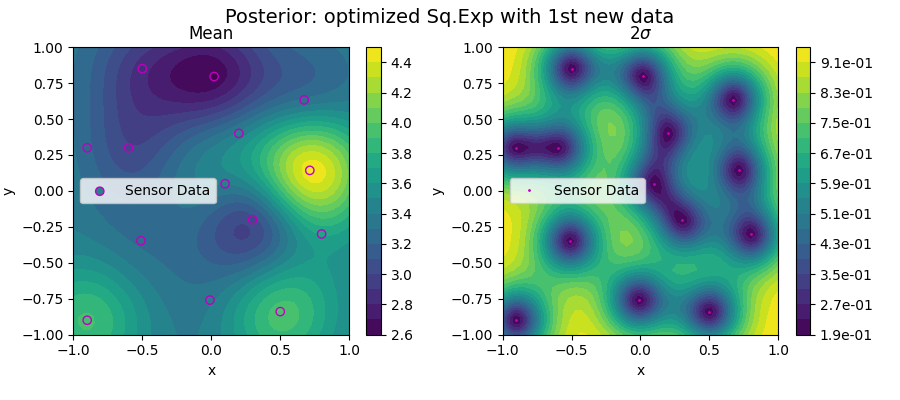

In [28]:
# add the new data and plot the posterior
xdata_new1 = [
    [
        -5.102040799999999487e-01,
        6.734693899999999456e-01,
        7.142857099999999626e-01,
        2.040816000000000158e-02],
    [
        -3.469387800000000022e-01,
        6.326530599999999893e-01,
        1.428571399999999936e-01,
        7.959183699999999861e-01,
    ]
]
ydata_new1 = [
    3.249887528688572669e+00,
    3.278017251997401349e+00,
    4.480098976113844778e+00,
    2.572843029623550493e+00,
]
xdata1 = np.hstack((xdata0, xdata_new1))
ydata1 = np.append(ydata0, ydata_new1)

pred_mean1, pred_cov1, kernel1 = run_tuned_gpr(xdata1, ydata1, NUM_POINTS, NOISE, meanf)
plot_gpr(pred_mean1, pred_cov1, xdata1, ydata1, 'Posterior: optimized Sq.Exp with 1st new data')

New points from reducing variance:
[[-0.91836735 -0.26530612]
 [ 0.95918367 -0.75510204]
 [-0.91836735  0.87755102]]


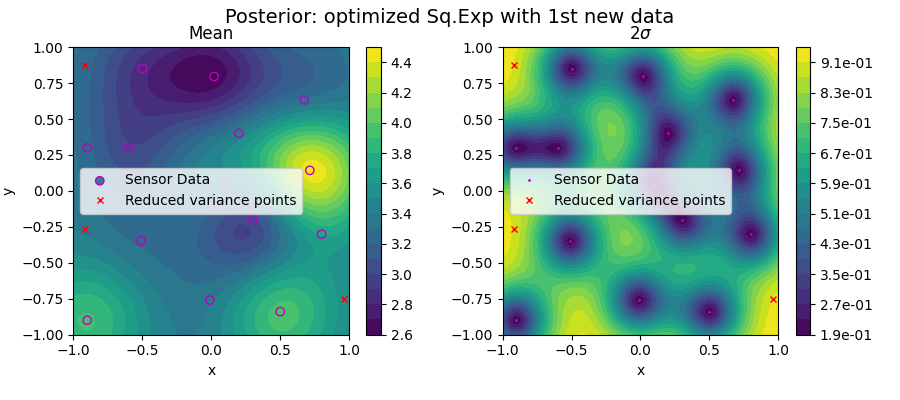

New points from maximizing expected improvement
[[ 1.          0.14285714]
 [ 0.91836735 -1.        ]
 [-0.51020408 -1.        ]]


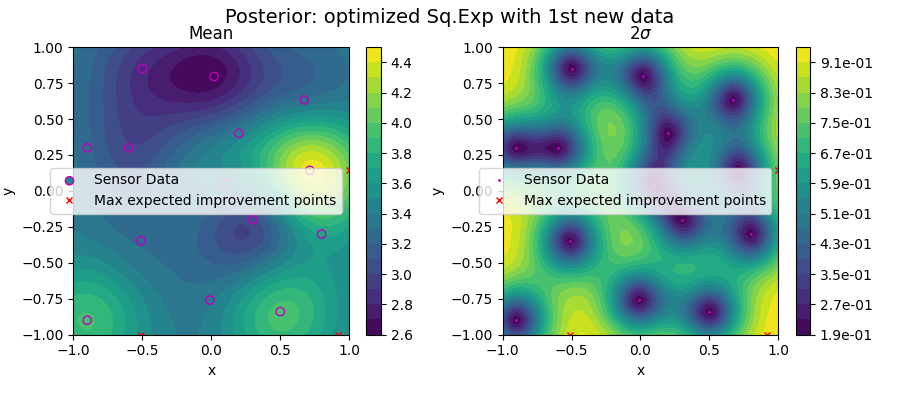

In [38]:
NUM_NEW_PTS_REDVAR = 3
new_pts_redvar = acquire_reduce_var(kernel1, xdata1, ydata1, NUM_POINTS, NUM_NEW_PTS_REDVAR)
print(f'New points from reducing variance:\n{new_pts_redvar.T}')
plot_gpr(pred_mean1, pred_cov1, xdata1, ydata1, 'Posterior: optimized Sq.Exp with 1st new data',
         new_pts_redvar, 'Reduced variance points')

NUM_NEW_PTS_EI = 3
new_pts_ei, ei = acquire_max_ei(kernel1, xdata1, ydata1, NUM_POINTS, NUM_NEW_PTS_EI, 1)
print(f'New points from maximizing expected improvement\n{new_pts_ei.T}')
plot_gpr(pred_mean1, pred_cov1, xdata1, ydata1, 'Posterior: optimized Sq.Exp with 1st new data',
         new_pts_ei, 'Max expected improvement points')

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 14.320167297784781
        x: [ 7.346e-01  2.867e-01]
      nit: 11
      jac: [-3.815e-06 -1.192e-06]
 hess_inv: [[ 5.208e-03  2.916e-03]
            [ 2.916e-03  7.497e-03]]
     nfev: 63
     njev: 21
Optimal hyperparams for Sq.Exp:
likelihood: -14.32
tau: 0.73
l: 0.29
Data variance: 0.269713881119317
Max Posterior variance: 0.2752351174551624


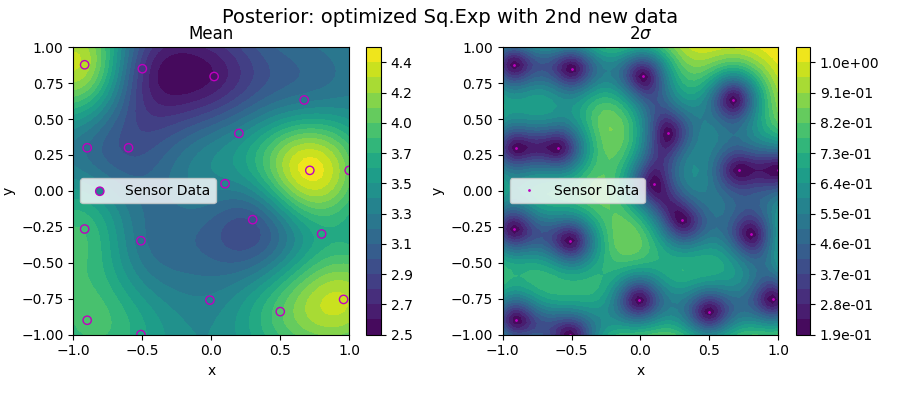

In [29]:
xdata_new2 = [
    [
        -9.183673500000000267e-01,
        9.591836700000000437e-01,
        -9.183673500000000267e-01,
        1.000000000000000000e+00,
        -5.102040799999999487e-01,
    ],
    [
        -2.653061199999999786e-01,
        -7.551020400000000299e-01,
        8.775510199999999594e-01,
        1.428571399999999936e-01,
        -1.000000000000000000e+00,
    ]
]
ydata_new2 = [
    3.858313698263417191e+00,
    4.318526102393465571e+00,
    4.275198101677585960e+00,
    3.986454393721211797e+00,
    3.679415033073086594e+00,
]
xdata2 = np.hstack((xdata1, xdata_new2))
ydata2 = np.append(ydata1, ydata_new2)

pred_mean2, pred_cov2, kernel2 = run_tuned_gpr(xdata2, ydata2, NUM_POINTS, NOISE, meanf)
plot_gpr(pred_mean2, pred_cov2, xdata2, ydata2, 'Posterior: optimized Sq.Exp with 2nd new data')

New points from reducing variance:
[[ 0.83673469  1.        ]
 [ 0.34693878  0.95918367]
 [-0.10204082 -0.30612245]]


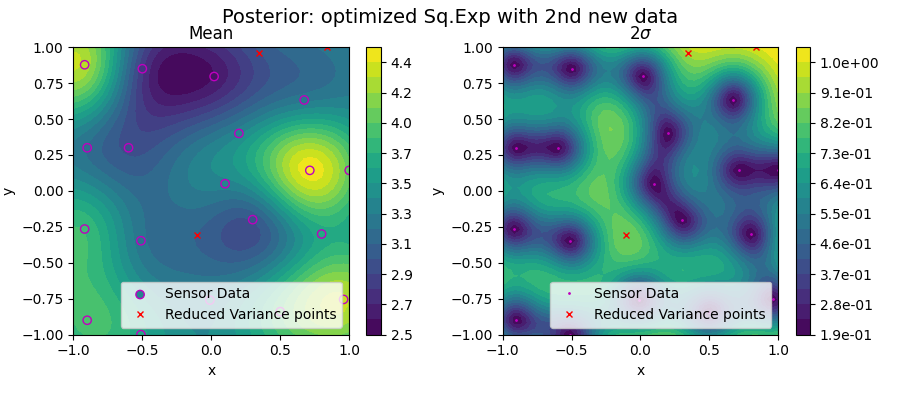

New points from maximizing expected improvement
[[ 0.83673469 -0.95918367]
 [-1.          1.        ]
 [ 0.59183673  0.2244898 ]]


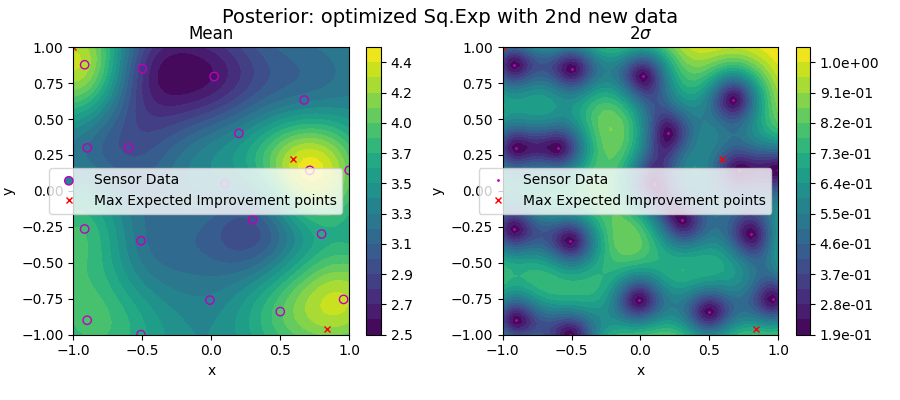

In [39]:
NUM_NEW_PTS_REDVAR = 3
new_pts_redvar = acquire_reduce_var(kernel2, xdata2, ydata2, NUM_POINTS, NUM_NEW_PTS_REDVAR)
print(f'New points from reducing variance:\n{new_pts_redvar.T}')
plot_gpr(pred_mean2, pred_cov2, xdata2, ydata2, 'Posterior: optimized Sq.Exp with 2nd new data',
         new_pts_redvar, 'Reduced Variance points')

NUM_NEW_PTS_EI = 3
new_pts_ei, ei = acquire_max_ei(kernel2, xdata2, ydata2, NUM_POINTS, NUM_NEW_PTS_EI, 0.1)
print(f'New points from maximizing expected improvement\n{new_pts_ei.T}')
plot_gpr(pred_mean2, pred_cov2, xdata2, ydata2, 'Posterior: optimized Sq.Exp with 2nd new data',
         new_pts_ei, 'Max Expected Improvement points')